In [1]:
# Md. Shakhawat Hossain
# Bachelor of Science in Computer Science and Engineering (BSCSE)
# Department of Electrical and Computer Engineering
# North South University
# Plot # 15, Block # B, Bashundhara
# Dhaka – 1229, Bangladesh
# Gmail: shakhawat.hossain07.edu@gmail.com

# Install necessary libraries
!pip install qiskit qiskit-aer imbalanced-learn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.0 MB/s eta 0:00:00


In [2]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=4f0b43021989095339d2f6b9ec4db64542f61e00afbee4d7f91682ff8fd0aa65
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [3]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer
from imblearn.over_sampling import ADASYN
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

In [4]:
# Mount Google Drive to access dataset files
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set the root directory of the dataset
root_dir = "/content/drive/MyDrive/Oral Disease Dataset"

In [6]:
# Define a function to create a DataFrame with image paths and labels from the dataset
def create_dataframe(root_dir):
    data = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jpg'):
                label = os.path.basename(subdir)
                data.append([os.path.join(subdir, file), label])
    return pd.DataFrame(data, columns=['image_path', 'label'])


In [7]:
# Load dataset information into a DataFrame
data_df = create_dataframe(root_dir)
data_df['label'] = data_df['label'].astype('category').cat.codes
data_df.dropna(inplace=True)

In [8]:
# Check unique classes and class distribution
print("Unique classes in the dataset:", data_df['label'].unique())
print("Class distribution:\n", data_df['label'].value_counts())

Unique classes in the dataset: [3 2 0 5 4 1]
Class distribution:
 label
2    2350
0    1306
5     342
3     265
1     219
4     183
Name: count, dtype: int64


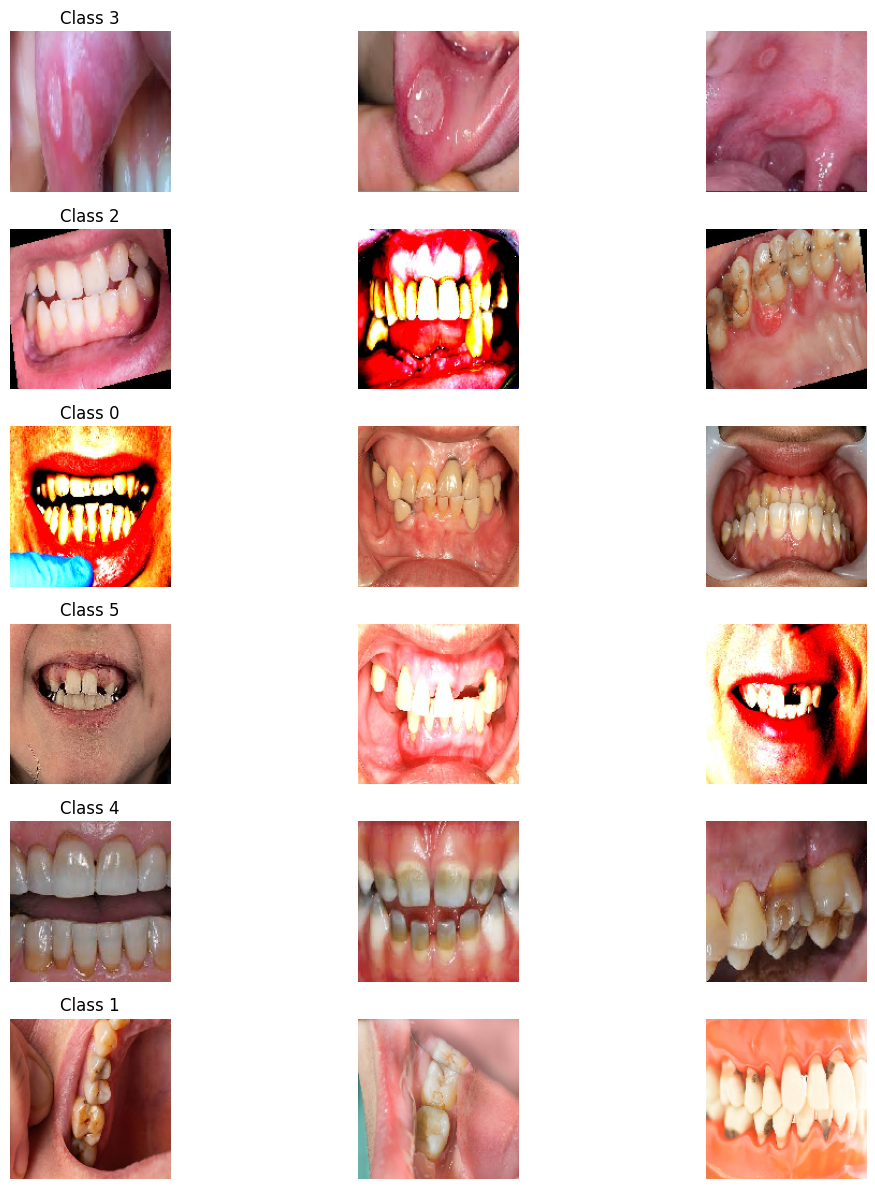

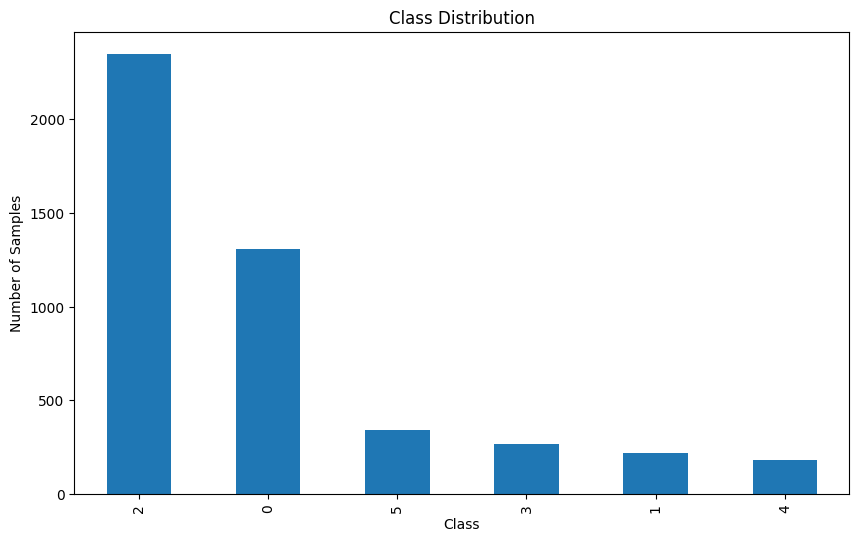

In [9]:
# Function to plot sample images from each class
def plot_sample_images(data_df, n_samples=3, target_size=(150, 150)):
    classes = data_df['label'].unique()
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(12, 12))

    for idx, cls in enumerate(classes):
        sample_paths = data_df[data_df['label'] == cls]['image_path'].sample(n=n_samples).tolist()
        for i, image_path in enumerate(sample_paths):
            img = load_img(image_path, target_size=target_size)
            axes[idx, i].imshow(img)
            axes[idx, i].axis('off')
            if i == 0:
                axes[idx, i].set_title(f"Class {cls}")

    plt.tight_layout()
    plt.show()

# Function to plot class distribution
def plot_class_distribution(data_df):
    class_counts = data_df['label'].value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

# Plot sample images
plot_sample_images(data_df)

# Plot class distribution
plot_class_distribution(data_df)

In [10]:
# Define a function to load and resize images
def load_and_resize_images(image_paths, target_size=(150, 150)):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=target_size)
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

In [11]:
# Load images into arrays and labels into a NumPy array
X_images = load_and_resize_images(data_df['image_path'])
y_labels = data_df['label'].values

In [12]:
# Split the data into training and test sets using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

In [13]:
# Apply ADASYN to balance the training data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape(-1, 150, 150, 3)

In [14]:
# Function to plot class distribution
def plot_class_distribution(labels, title, color):
    df = pd.DataFrame(labels, columns=['label'])
    plt.figure(figsize=(10, 6))
    df['label'].value_counts().plot(kind='bar', color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

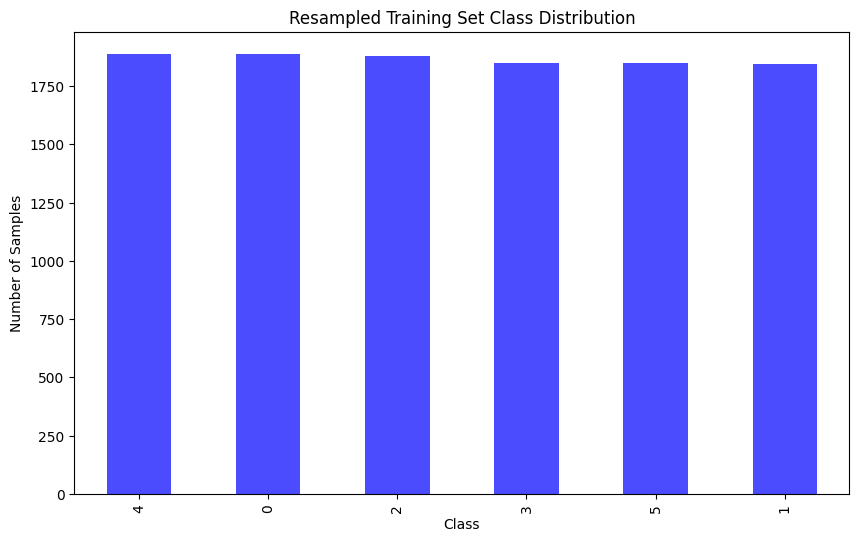

In [15]:
# Plot class distribution for the resampled training set
plot_class_distribution(y_train_resampled, 'Resampled Training Set Class Distribution', 'blue')

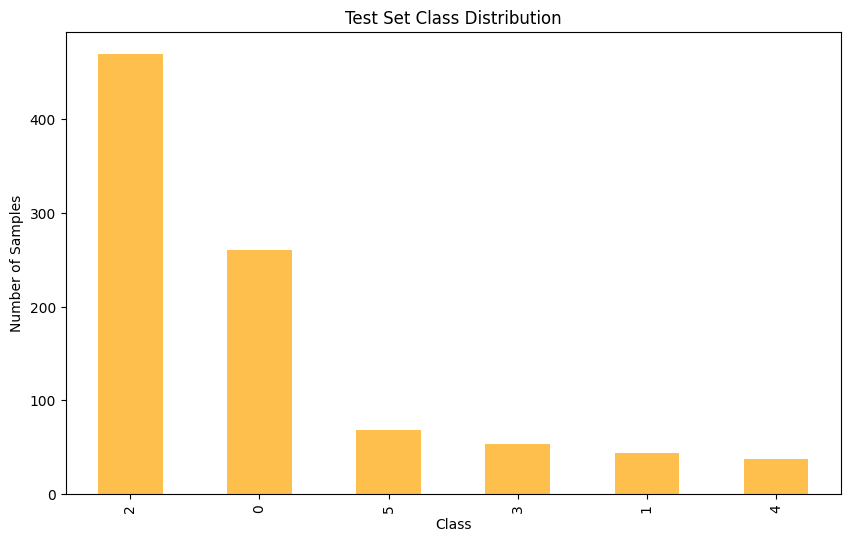

In [16]:
# Plot class distribution for the test set
plot_class_distribution(y_test, 'Test Set Class Distribution', 'orange')

In [17]:
# Convert data to PyTorch tensors and reshape
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

In [18]:
# Convert labels to one-hot encoding
n_classes = len(data_df['label'].unique())
y_train_tensor = F.one_hot(torch.tensor(y_train_resampled, dtype=torch.long), num_classes=n_classes).float()
y_test_tensor = F.one_hot(torch.tensor(y_test, dtype=torch.long), num_classes=n_classes).float()

In [19]:
# Check tensor shapes
print(f"Shape of X_train_tensor: {X_train_tensor.shape}")
print(f"Shape of y_train_tensor: {y_train_tensor.shape}")
print(f"Shape of X_test_tensor: {X_test_tensor.shape}")
print(f"Shape of y_test_tensor: {y_test_tensor.shape}")

Shape of X_train_tensor: torch.Size([11203, 3, 150, 150])
Shape of y_train_tensor: torch.Size([11203, 6])
Shape of X_test_tensor: torch.Size([933, 3, 150, 150])
Shape of y_test_tensor: torch.Size([933, 6])


In [20]:
# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
# Define the MyQuantumCircuit class
class MyQuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.backend = backend
        self.shots = shots

        # Define the circuit
        self.circuit = QuantumCircuit(n_qubits)
        self.theta = Parameter("theta")
        self.circuit.h(0)
        self.circuit.ry(self.theta, 0)
        self.circuit.measure_all()

    def run(self, theta):
        # Ensure theta is passed correctly
        if isinstance(theta, (list, np.ndarray)):
            theta = theta[0]

        # Create a new circuit with the parameter value
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()

        # Transpile the circuit
        transpiled_circuit = transpile(circuit, self.backend)

        # Execute the job using the BackendV2 interface
        job = self.backend.run(transpiled_circuit, shots=self.shots)
        result = job.result()
        counts = result.get_counts()

        # Calculate expectation value
        counts_array = np.array(list(counts.values()))
        states_array = np.array([int(state, 2) for state in counts.keys()])
        probabilities = counts_array / self.shots
        expectation = np.sum(states_array * probabilities)

        return np.array([expectation])


Counts: {'1': 100}


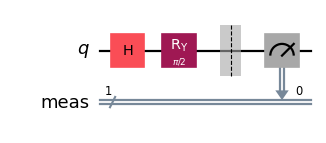

In [22]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer

class MyQuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.backend = backend
        self.shots = shots

        # Define the circuit
        self.circuit = QuantumCircuit(n_qubits)
        self.theta = Parameter("theta")
        self.circuit.h(0)
        self.circuit.ry(self.theta, 0)
        self.circuit.measure_all()

    def run(self, theta):
        # Ensure theta is passed correctly
        if isinstance(theta, (list, np.ndarray)):
            theta = theta[0]

        # Create a new circuit with the parameter value
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()

        # Transpile the circuit
        transpiled_circuit = transpile(circuit, self.backend)

        # Execute the job using the BackendV2 interface
        job = self.backend.run(transpiled_circuit, shots=self.shots)
        result = job.result()
        counts = result.get_counts()

        # Calculate expectation value
        counts_array = np.array(list(counts.values()))
        states_array = np.array([int(state, 2) for state in counts.keys()])
        probabilities = counts_array / self.shots
        expectation = np.sum(states_array * probabilities)

        return np.array([expectation])

    def draw_circuit(self, theta):
        # Create a new circuit with the parameter value
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()

        # Transpile the circuit
        transpiled_circuit = transpile(circuit, AerSimulator())

        # Execute the job using the AerSimulator
        job = AerSimulator().run(transpiled_circuit, shots=100)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)

        # Print the counts
        print("Counts:", counts)

        # Draw the circuit and show the plot
        figure = circuit.draw(output='mpl', scale=0.8)
        plt.show()
        return figure

# Initialize the quantum circuit and plot it
quantum_circuit = MyQuantumCircuit(1, AerSimulator(), 100)
quantum_circuit.draw_circuit(np.pi / 2)


In [23]:
# Define the HybridFunction class
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = []

        for sample in input:
            # Run quantum circuit for each input
            expectation_z.append(ctx.quantum_circuit.run([sample.item()]))

        result = torch.tensor(expectation_z, dtype=torch.float32)
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, _ = ctx.saved_tensors
        input_list = input.tolist()

        # Compute gradients using parameter shift
        gradients = []
        for i in range(len(input_list)):
            shift_right = input_list[i] + ctx.shift
            shift_left = input_list[i] - ctx.shift
            expectation_right = ctx.quantum_circuit.run([shift_right])
            expectation_left = ctx.quantum_circuit.run([shift_left])
            gradient = (expectation_right - expectation_left) / (2 * ctx.shift)
            gradients.append(gradient)

        gradients = torch.tensor(gradients, dtype=torch.float32)
        return gradients * grad_output, None, None


In [24]:
# Define the Hybrid class
class Hybrid(nn.Module):
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = MyQuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [25]:
# Define the CNN Model with Quantum Layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d()
        self.hybrid = Hybrid(AerSimulator(), 100, np.pi / 2)
        self._flattened_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self._flattened_size, 64)
        self.fc2 = nn.Linear(64, n_classes)  # Update for multi-class classification

    def _get_flattened_size(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        return int(np.prod(x.size()))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # Output shape matches target

In [26]:
# Initialize model, optimizer, and loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

# Early Stopping Parameters
patience = 10
best_loss = float('inf')
early_stop_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training loop with early stopping and learning rate scheduler
epochs = 100
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())

    avg_loss = sum(total_loss) / len(total_loss)
    loss_list.append(avg_loss)

    # Step the scheduler
    scheduler.step(avg_loss)

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_list[-1]:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/100, Loss: 1.1054
Epoch 2/100, Loss: 0.4555
Epoch 3/100, Loss: 0.3065
Epoch 4/100, Loss: 0.2435
Epoch 5/100, Loss: 0.2163
Epoch 6/100, Loss: 0.1953
Epoch 7/100, Loss: 0.1875
Epoch 8/100, Loss: 0.1767
Epoch 9/100, Loss: 0.1865
Epoch 10/100, Loss: 0.1646
Epoch 11/100, Loss: 0.1608
Epoch 12/100, Loss: 0.1534
Epoch 13/100, Loss: 0.1492
Epoch 14/100, Loss: 0.1456
Epoch 15/100, Loss: 0.1457
Epoch 16/100, Loss: 0.1376
Epoch 17/100, Loss: 0.1399
Epoch 18/100, Loss: 0.1484
Epoch 19/100, Loss: 0.1378
Epoch 20/100, Loss: 0.1335
Epoch 21/100, Loss: 0.1291
Epoch 22/100, Loss: 0.1352
Epoch 23/100, Loss: 0.1288
Epoch 24/100, Loss: 0.1279
Epoch 25/100, Loss: 0.1232
Epoch 26/100, Loss: 0.1249
Epoch 27/100, Loss: 0.1306
Epoch 28/100, Loss: 0.1213
Epoch 29/100, Loss: 0.1244
Epoch 30/100, Loss: 0.1169
Epoch 31/100, Loss: 0.1232
Epoch 32/100, Loss: 0.1198
Epoch 33/100, Loss: 0.1170
Epoch 34/100, Loss: 0.1180
Epoch 35/100, Loss: 0.1226
Epoch 36/100, Loss: 0.1169
Epoch 37/100, Loss: 0.1125
Epoch 38/1

<All keys matched successfully>

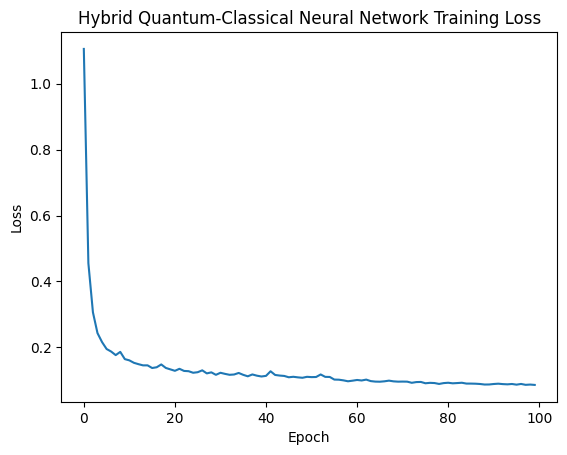

In [28]:
# Plot training loss
plt.plot(loss_list)
plt.title('Hybrid Quantum-Classical Neural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [29]:
# Evaluate model
model.eval()
correct = 0
total_loss = []
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        loss = loss_func(output, target)
        total_loss.append(loss.item())

        # Store the raw output probabilities
        probs = F.softmax(output, dim=1).cpu().numpy()
        all_probs.extend(probs)

        pred = output.argmax(dim=1, keepdim=True).cpu().numpy()
        target = target.argmax(dim=1, keepdim=True).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(target)

avg_loss = sum(total_loss) / len(total_loss)
accuracy = (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels) * 100
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

# Ensure all_labels is 1D and all_probs is 2D
all_labels_flat = np.array(all_labels).ravel()
all_probs_array = np.array(all_probs)

auroc = roc_auc_score(all_labels_flat, all_probs_array, average='macro', multi_class='ovo')

print(f"Average Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Macro-F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUROC Score: {auroc:.2f}")


Average Test Loss: 2.5051
Test Accuracy: 64.42%
Macro-F1 Score: 0.55
Precision: 0.63
Recall: 0.51
AUROC Score: 0.85


Confusion Matrix:
 [[170   2  83   0   2   4]
 [  8  10  21   2   0   3]
 [126   0 335   1   1   7]
 [  2   5   5  37   3   1]
 [ 12   4  14   0   6   1]
 [ 15   1   6   2   1  43]]


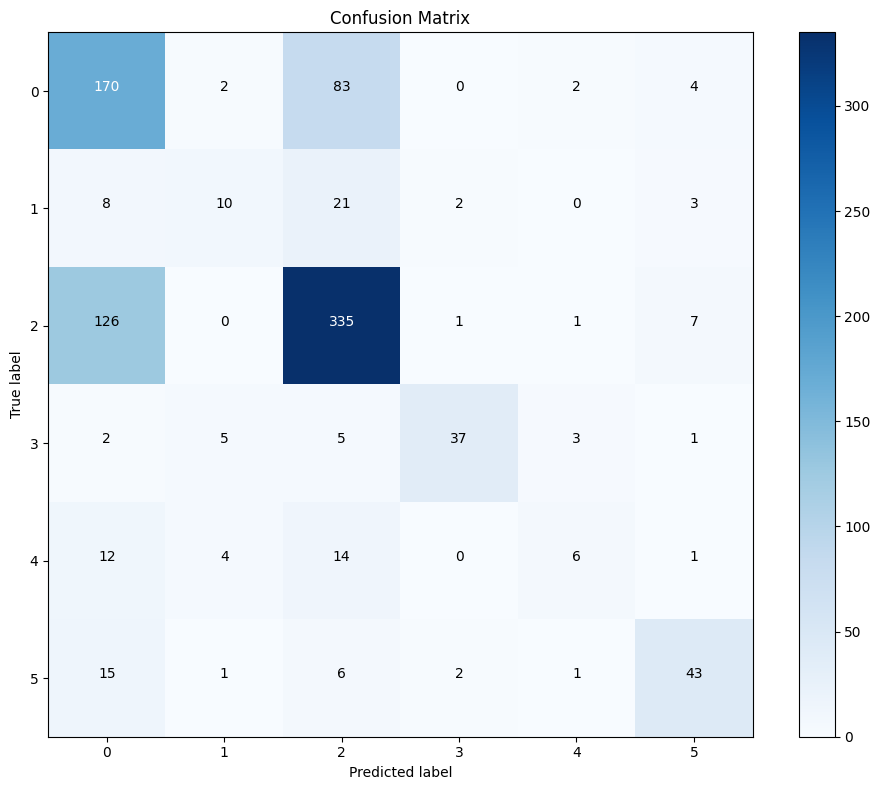

In [30]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [31]:
!pip install torchsummary
from torchsummary import summary

# Assuming you have already defined and initialized your model
summary(model, input_size=(3, 150, 150))
!pip install torchviz
from torchviz import make_dot

# Forward a dummy input through the model to visualize the computational graph
x = torch.randn(1, 3, 150, 150)
y = model(x)

# Create a visual representation of the model
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_architecture')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 146, 146]           1,216
         MaxPool2d-2           [-1, 16, 73, 73]               0
            Conv2d-3           [-1, 32, 69, 69]          12,832
         MaxPool2d-4           [-1, 32, 34, 34]               0
         Dropout2d-5           [-1, 32, 34, 34]               0
            Linear-6                   [-1, 64]       2,367,552
            Linear-7                    [-1, 6]             390
Total params: 2,381,990
Trainable params: 2,381,990
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 4.98
Params size (MB): 9.09
Estimated Total Size (MB): 14.32
----------------------------------------------------------------


'model_architecture.png'

                                         Model Architecture
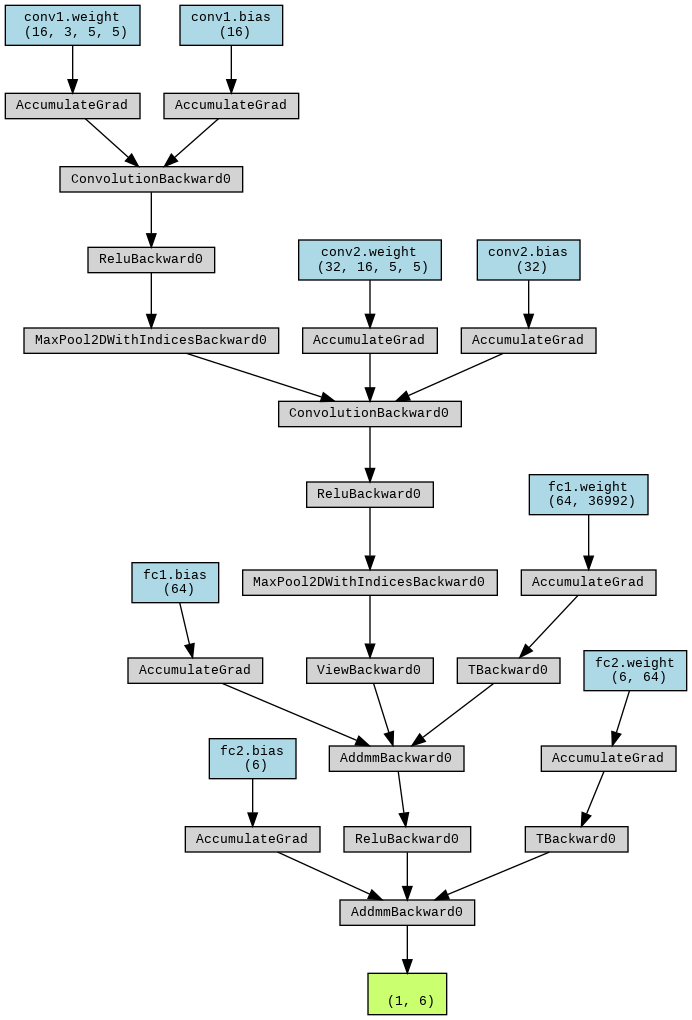